In [1]:
import os
import requests

import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR

from OrnsteinUhlenbeck.n_standart_ou import VasicekModel, mle_ou
from plt_utils import save_plot

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
DATASETS_URL = 'https://storage.googleapis.com/3jane-articles/datasets/1-autocorrelation'


def get_dataset(dataset, dataset_dir='datasets', force_download=False):
    if not os.path.exists(dataset_dir):
        os.mkdir(dataset_dir)
    
    dataset_path = os.path.join(dataset_dir, dataset)
    
    if force_download or not os.path.exists(dataset_path):
        r = requests.get(f'{DATASETS_URL}/{dataset}')
        r.raise_for_status()
        with open(dataset_path, 'wb') as dest_file:
            dest_file.write(r.content)
    
    return pd.read_hdf(dataset_path, key='table')

In [23]:
raw_data = get_dataset('BTC_USD_bitfinex_1m.hdf')
raw_data

,open,high,low,close,volume
timestamp,,,,,
2014-07-01 00:00:00,642.26000,642.26,640.78,641.01,0.218858
2014-07-01 00:01:00,642.23000,645.00,642.23,644.02,6.470715
2014-07-01 00:02:00,644.02000,648.15,644.02,648.15,108.660210
2014-07-01 00:03:00,646.95000,649.99,646.00,648.69,341.165312
2014-07-01 00:04:00,648.76000,648.76,646.00,648.31,16.183607
...,...,...,...,...,...
2019-06-30 23:55:00,10707.00000,10767.00,10668.00,10746.00,132.364633
2019-06-30 23:56:00,10745.00000,10769.00,10701.00,10701.00,23.433025
2019-06-30 23:57:00,10706.00000,10759.00,10705.00,10748.00,16.022461


In [24]:
x = raw_data['close'].values
x

array([  641.01,   644.02,   648.15, ..., 10748.  , 10745.  , 10805.  ])

In [25]:
dt = 1  # minute in days
t = np.arange(0, len(x), dt)

In [27]:
plt.xlabel("t")
plt.ylabel("S")
plt.plot(t, x, color="black")
save_plot(plt, "bitcoin")

In [9]:
train_size = int(len(x) * 0.8)

#LSTM preprocess
X = [[v] for v in x]

# Vasicek preprocess
v_train, v_test = list(x[:train_size]), x[train_size:]

# Naive method

Test MSE: 0.521283


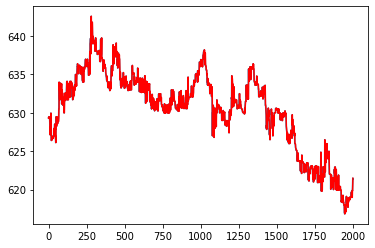

In [9]:
predictions = [v_train[-1]]
predictions.extend(v_test[:-1])
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# Drift method

Test MSE: 0.521331


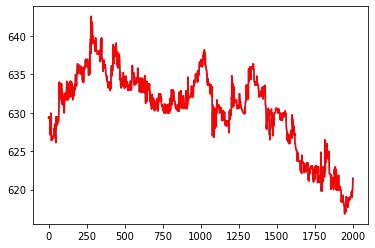

In [10]:
history_len = len(v_train)
predictions = [(history_len * v_train[-1] - v_train[0]) / (history_len - 1)]
for s_t in v_test[:-1]:
    predictions.append((history_len * s_t - v_train[0]) / (history_len - 1))
    history_len += 1
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# Vasicek

In [11]:
result = mle_ou(t[:train_size], v_train)
kappa = result.params["kappa"].value
theta = result.params["theta"].value
sigma = result.params["sigma"].value
q_predicted = {"kappa": kappa, "theta": theta, "sigma": sigma}
print(q_predicted)

{'kappa': 0.0026476476185300912, 'theta': 635.985568507254, 'sigma': 0.9281994441211842}


In [12]:
def predict(s_t, kappa, theta, sigma):
    return s_t + kappa * (theta - s_t) * dt

Test MSE: 0.520523


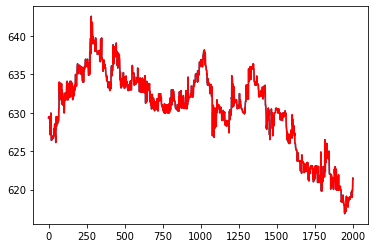

In [16]:
predictions = [predict(v_train[-1], **q_predicted)]

for s in v_test[:-1]:
    predictions.append(predict(s, **q_predicted))
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# LSTM

In [17]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))
        output, (hn, cn) = self.lstm_2(output, (hn, cn))
        output, (hn, cn) = self.lstm_3(output, (hn, cn))
        hn = hn.view(-1, self.hidden_size)
        
        out = self.relu(hn)
        out = self.fc(out)
        
        return out

In [18]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [19]:
seq_length = 50

lstm_x, lstm_y = sliding_windows(X, seq_length)

test_size = len(lstm_y) - train_size

trainX = torch.Tensor(np.array(lstm_x[0:train_size]))
trainY = torch.Tensor(np.array(lstm_y[0:train_size]))

testX = torch.Tensor(np.array(lstm_x[train_size:len(lstm_x)]))
testY = torch.Tensor(np.array(lstm_y[train_size:len(lstm_y)]))

In [20]:
dataloaderX = DataLoader(trainX, batch_size=25000, shuffle=False)
dataloaderY = DataLoader(trainY, batch_size=25000, shuffle=False)
test_dataloaderX = DataLoader(testX, batch_size=25000, shuffle=False)
test_dataloaderY = DataLoader(testY, batch_size=25000, shuffle=False)

In [21]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 50
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.995) 

# Train the model
for epoch in range(num_epochs):
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()
        
#         print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")
    print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

Epoch: 0, Batch: 0 loss: 404563.59375
Epoch: 1, Batch: 0 loss: 404189.84375
Epoch: 2, Batch: 0 loss: 403371.28125
Epoch: 3, Batch: 0 loss: 402667.46875
Epoch: 4, Batch: 0 loss: 402122.34375
Epoch: 5, Batch: 0 loss: 401641.5
Epoch: 6, Batch: 0 loss: 401238.09375
Epoch: 7, Batch: 0 loss: 400891.28125
Epoch: 8, Batch: 0 loss: 400577.3125
Epoch: 9, Batch: 0 loss: 400279.75
Epoch: 10, Batch: 0 loss: 399989.78125
Epoch: 11, Batch: 0 loss: 399703.21875
Epoch: 12, Batch: 0 loss: 399418.46875
Epoch: 13, Batch: 0 loss: 399134.78125
Epoch: 14, Batch: 0 loss: 398851.9375
Epoch: 15, Batch: 0 loss: 398570.0
Epoch: 16, Batch: 0 loss: 398288.96875
Epoch: 17, Batch: 0 loss: 398009.125
Epoch: 18, Batch: 0 loss: 397730.375
Epoch: 19, Batch: 0 loss: 397452.875
Epoch: 20, Batch: 0 loss: 397176.59375
Epoch: 21, Batch: 0 loss: 396901.78125
Epoch: 22, Batch: 0 loss: 396628.34375
Epoch: 23, Batch: 0 loss: 396356.375
Epoch: 24, Batch: 0 loss: 396085.875
Epoch: 25, Batch: 0 loss: 395816.84375
Epoch: 26, Batch: 0

Epoch: 214, Batch: 0 loss: 364833.96875
Epoch: 215, Batch: 0 loss: 364740.0
Epoch: 216, Batch: 0 loss: 364646.4375
Epoch: 217, Batch: 0 loss: 364553.40625
Epoch: 218, Batch: 0 loss: 364460.84375
Epoch: 219, Batch: 0 loss: 364368.75
Epoch: 220, Batch: 0 loss: 364277.15625
Epoch: 221, Batch: 0 loss: 364186.0625
Epoch: 222, Batch: 0 loss: 364095.4375
Epoch: 223, Batch: 0 loss: 364005.1875
Epoch: 224, Batch: 0 loss: 363915.53125
Epoch: 225, Batch: 0 loss: 363826.3125
Epoch: 226, Batch: 0 loss: 363737.46875
Epoch: 227, Batch: 0 loss: 363649.1875
Epoch: 228, Batch: 0 loss: 363561.34375
Epoch: 229, Batch: 0 loss: 363473.90625
Epoch: 230, Batch: 0 loss: 363386.96875
Epoch: 231, Batch: 0 loss: 363300.46875
Epoch: 232, Batch: 0 loss: 363214.375
Epoch: 233, Batch: 0 loss: 363128.78125
Epoch: 234, Batch: 0 loss: 363043.625
Epoch: 235, Batch: 0 loss: 362958.9375
Epoch: 236, Batch: 0 loss: 362874.5625
Epoch: 237, Batch: 0 loss: 362790.78125
Epoch: 238, Batch: 0 loss: 362707.34375
Epoch: 239, Batch: 

Epoch: 424, Batch: 0 loss: 352738.65625
Epoch: 425, Batch: 0 loss: 352706.5
Epoch: 426, Batch: 0 loss: 352674.65625
Epoch: 427, Batch: 0 loss: 352642.8125
Epoch: 428, Batch: 0 loss: 352611.21875
Epoch: 429, Batch: 0 loss: 352579.84375
Epoch: 430, Batch: 0 loss: 352548.5
Epoch: 431, Batch: 0 loss: 352517.40625
Epoch: 432, Batch: 0 loss: 352486.40625
Epoch: 433, Batch: 0 loss: 352455.625
Epoch: 434, Batch: 0 loss: 352424.96875
Epoch: 435, Batch: 0 loss: 352394.5
Epoch: 436, Batch: 0 loss: 352364.125
Epoch: 437, Batch: 0 loss: 352333.90625
Epoch: 438, Batch: 0 loss: 352303.8125
Epoch: 439, Batch: 0 loss: 352274.0
Epoch: 440, Batch: 0 loss: 352244.25
Epoch: 441, Batch: 0 loss: 352214.6875
Epoch: 442, Batch: 0 loss: 352185.21875
Epoch: 443, Batch: 0 loss: 352155.9375
Epoch: 444, Batch: 0 loss: 352126.8125
Epoch: 445, Batch: 0 loss: 352097.8125
Epoch: 446, Batch: 0 loss: 352068.96875
Epoch: 447, Batch: 0 loss: 352040.25
Epoch: 448, Batch: 0 loss: 352011.71875
Epoch: 449, Batch: 0 loss: 35198

Epoch: 634, Batch: 0 loss: 348571.71875
Epoch: 635, Batch: 0 loss: 348560.53125
Epoch: 636, Batch: 0 loss: 348549.46875
Epoch: 637, Batch: 0 loss: 348538.4375
Epoch: 638, Batch: 0 loss: 348527.375
Epoch: 639, Batch: 0 loss: 348516.53125
Epoch: 640, Batch: 0 loss: 348505.625
Epoch: 641, Batch: 0 loss: 348494.84375
Epoch: 642, Batch: 0 loss: 348484.0625
Epoch: 643, Batch: 0 loss: 348473.28125
Epoch: 644, Batch: 0 loss: 348462.625
Epoch: 645, Batch: 0 loss: 348452.0625
Epoch: 646, Batch: 0 loss: 348441.53125
Epoch: 647, Batch: 0 loss: 348431.0
Epoch: 648, Batch: 0 loss: 348420.5625
Epoch: 649, Batch: 0 loss: 348410.1875
Epoch: 650, Batch: 0 loss: 348399.8125
Epoch: 651, Batch: 0 loss: 348389.53125
Epoch: 652, Batch: 0 loss: 348379.28125
Epoch: 653, Batch: 0 loss: 348369.03125
Epoch: 654, Batch: 0 loss: 348359.0
Epoch: 655, Batch: 0 loss: 348348.875
Epoch: 656, Batch: 0 loss: 348338.8125
Epoch: 657, Batch: 0 loss: 348328.84375
Epoch: 658, Batch: 0 loss: 348318.9375
Epoch: 659, Batch: 0 los

Epoch: 844, Batch: 0 loss: 347119.46875
Epoch: 845, Batch: 0 loss: 347115.59375
Epoch: 846, Batch: 0 loss: 347111.6875
Epoch: 847, Batch: 0 loss: 347107.84375
Epoch: 848, Batch: 0 loss: 347104.03125
Epoch: 849, Batch: 0 loss: 347100.1875
Epoch: 850, Batch: 0 loss: 347096.40625
Epoch: 851, Batch: 0 loss: 347092.5625
Epoch: 852, Batch: 0 loss: 347088.84375
Epoch: 853, Batch: 0 loss: 347085.0625
Epoch: 854, Batch: 0 loss: 347081.375
Epoch: 855, Batch: 0 loss: 347077.71875
Epoch: 856, Batch: 0 loss: 347073.9375
Epoch: 857, Batch: 0 loss: 347070.28125
Epoch: 858, Batch: 0 loss: 347066.71875
Epoch: 859, Batch: 0 loss: 347063.03125
Epoch: 860, Batch: 0 loss: 347059.40625
Epoch: 861, Batch: 0 loss: 347055.84375
Epoch: 862, Batch: 0 loss: 347052.25
Epoch: 863, Batch: 0 loss: 347048.65625
Epoch: 864, Batch: 0 loss: 347045.125
Epoch: 865, Batch: 0 loss: 347041.625
Epoch: 866, Batch: 0 loss: 347038.09375
Epoch: 867, Batch: 0 loss: 347034.625
Epoch: 868, Batch: 0 loss: 347031.125
Epoch: 869, Batch:

Test MSE: 340343.406250


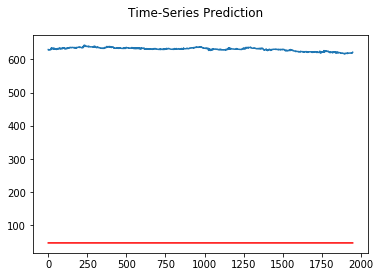

In [22]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)
    error += mean_squared_error(y_batch, outputs)
    
print('Test MSE: %.6f' % error)


plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()